In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
import medmnist
from medmnist import INFO
from PIL import Image

In [2]:
# --- 2. Definizione delle Classi per il Crop Intelligente ---

class ChestCropTransform:
    """
    Crop intelligente per radiografie toraciche che:
    1. Identifica la zona centrale del torace
    2. Ritaglia mantenendo solo l'area cardiopolmonare
    3. Ridimensiona alla dimensione finale
    """
    
    def __init__(self, final_size=224, crop_ratio=0.7):
        """
        Args:
            final_size: Dimensione finale dell'immagine
            crop_ratio: Percentuale dell'immagine da mantenere (0.7 = mantieni il 70% centrale)
        """
        self.final_size = final_size
        self.crop_ratio = crop_ratio
    
    def __call__(self, img):
        # MedMNIST restituisce array numpy, non PIL Images
        if isinstance(img, Image.Image):
            img_array = np.array(img)
        elif torch.is_tensor(img):
            img_array = img.numpy()
        else:
            img_array = img
        
        # Gestisci immagini con canali
        if len(img_array.shape) == 3:
            img_array = img_array.squeeze()
        
        h, w = img_array.shape
        
        # Calcola le dimensioni del crop centrale
        crop_h = int(h * self.crop_ratio)
        crop_w = int(w * self.crop_ratio)
        
        # Calcola le coordinate per centrare il crop
        start_h = (h - crop_h) // 2
        start_w = (w - crop_w) // 2
        
        # Esegui il crop
        cropped = img_array[start_h:start_h + crop_h, start_w:start_w + crop_w]
        
        # Restituisci sempre un array numpy
        return cropped

# %%
class AdaptiveChestCrop:
    """
    Crop più avanzato basato sull'intensità dei pixel
    """
    
    def __init__(self, final_size=224, intensity_threshold=0.1):
        self.final_size = final_size
        self.intensity_threshold = intensity_threshold
    
    def __call__(self, img):
        # MedMNIST restituisce array numpy, non PIL Images
        if isinstance(img, Image.Image):
            img_array = np.array(img)
        elif torch.is_tensor(img):
            img_array = img.numpy()
        else:
            img_array = img
        
        # Gestisci immagini con canali
        if len(img_array.shape) == 3:
            img_array = img_array.squeeze()
        
        # Normalizza l'immagine
        img_norm = (img_array - img_array.min()) / (img_array.max() - img_array.min())
        
        # Trova la bounding box della zona con più contrasto
        # Calcola il gradiente per trovare i bordi
        grad_y = np.abs(np.diff(img_norm, axis=0))
        grad_x = np.abs(np.diff(img_norm, axis=1))
        
        # Trova le coordinate dove c'è più informazione (bordi)
        edge_map = np.zeros_like(img_norm)
        edge_map[:-1, :] += grad_y
        edge_map[:, :-1] += grad_x
        
        # Trova la bounding box della zona con più edge
        coords = np.where(edge_map > self.intensity_threshold)
        
        if len(coords[0]) > 0:
            y_min, y_max = coords[0].min(), coords[0].max()
            x_min, x_max = coords[1].min(), coords[1].max()
            
            # Aggiungi un po' di padding
            h, w = img_array.shape
            padding = min(h, w) // 10
            
            y_min = max(0, y_min - padding)
            y_max = min(h, y_max + padding)
            x_min = max(0, x_min - padding)
            x_max = min(w, x_max + padding)
            
            cropped = img_array[y_min:y_max, x_min:x_max]
        else:
            # Fallback al crop centrale se non trova bordi significativi
            h, w = img_array.shape
            crop_h, crop_w = int(h * 0.7), int(w * 0.7)
            start_h, start_w = (h - crop_h) // 2, (w - crop_w) // 2
            cropped = img_array[start_h:start_h + crop_h, start_w:start_w + crop_w]
        
        # Restituisci sempre un array numpy
        return cropped


In [9]:
# --- 3. Configurazione delle Trasformazioni ---

data_flag = 'chestmnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# OPZIONE 1: Crop semplice (più conservativo)
data_transform_simple_crop = transforms.Compose([
    ChestCropTransform(final_size=224, crop_ratio=0.7),
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),  # Direttamente da numpy a tensor
    transforms.Normalize(mean=[.5], std=[.5])
])

# OPZIONE 2: Crop adattivo (più aggressivo)
data_transform_adaptive_crop = transforms.Compose([
    AdaptiveChestCrop(final_size=224, intensity_threshold=0.05),
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),  # Direttamente da numpy a tensor
    transforms.Normalize(mean=[.5], std=[.5])
])

# OPZIONE 3: Crop + Data Augmentation per migliorare la robustezza
data_transform_crop_augmented = transforms.Compose([
    ChestCropTransform(final_size=224, crop_ratio=0.7),
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=5),  # Piccole rotazioni
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Piccoli spostamenti
    transforms.Normalize(mean=[.5], std=[.5])
])

# Scegli quale trasformazione usare (puoi cambiare questa riga)
data_transform = data_transform_crop_augmented
print("Usando crop semplice (70% centrale)")


Usando crop semplice (70% centrale)


In [10]:
# --- 4. Caricamento Dataset con Crop Intelligente ---

train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

print(f"Dataset '{data_flag}' caricato con crop intelligente.")
print(f"Dimensione training set: {len(train_dataset)}")
print(f"Dimensione test set: {len(test_dataset)}")


Dataset 'chestmnist' caricato con crop intelligente.
Dimensione training set: 78468
Dimensione test set: 22433


Visualizzando l'effetto del crop intelligente...


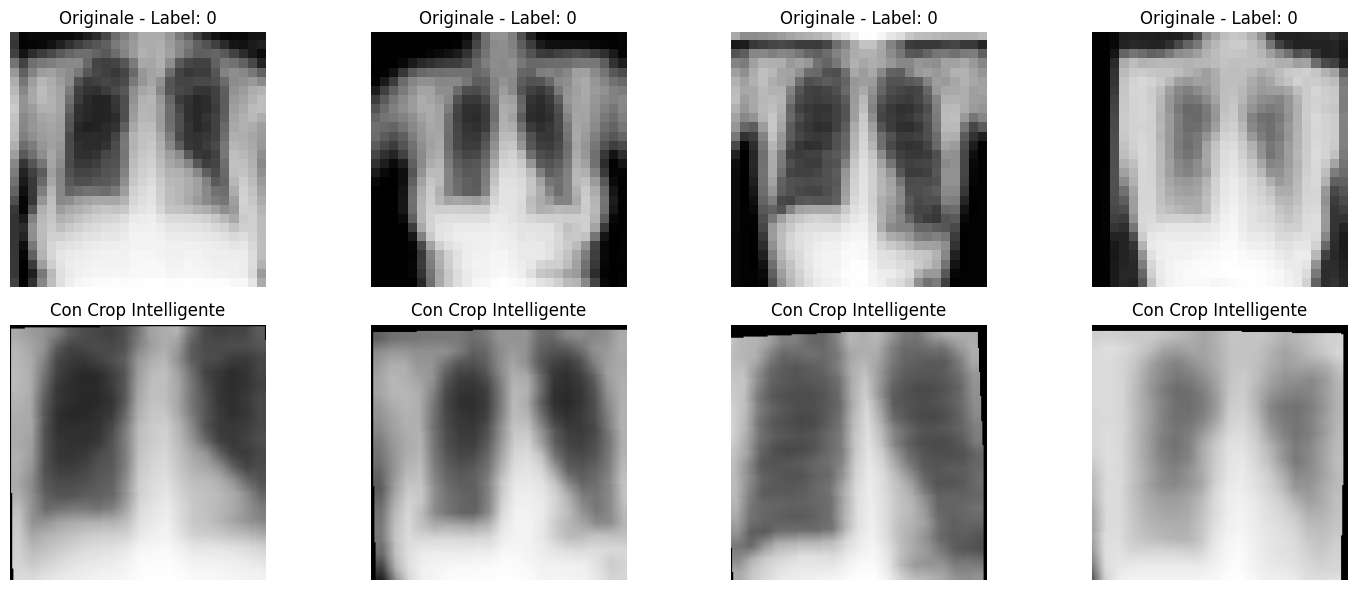

In [13]:
def visualize_crop_effect(dataset, num_samples=4):
    """
    Visualizza alcune immagini prima e dopo il crop per vedere l'effetto
    """
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    # Dataset originale (senza crop)
    original_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    original_dataset = DataClass(split='train', transform=original_transform, download=False)
    
    for i in range(num_samples):
        # Immagine originale
        orig_img, label = original_dataset[i]
        axes[0, i].imshow(orig_img.squeeze(), cmap='gray')
        axes[0, i].set_title(f"Originale - Label: {label[1].item()}")
        axes[0, i].axis('off')
        
        # Immagine con crop
        crop_img, _ = dataset[i]
        axes[1, i].imshow(crop_img.squeeze(), cmap='gray')
        axes[1, i].set_title("Con Crop Intelligente")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualizza l'effetto del crop
print("Visualizzando l'effetto del crop intelligente...")
visualize_crop_effect(train_dataset)


In [14]:
# --- 6. Definizione del Modello Lineare ---

class SimpleLinearClassifier(nn.Module):
    def __init__(self):
        super(SimpleLinearClassifier, self).__init__()
        self.linear = nn.Linear(224 * 224, 1) # Input 224*224=50176, Output 1 (score)
    
    def forward(self, x):
        x = x.view(-1, 224 * 224) # Appiattisci l'immagine
        x = self.linear(x)
        return x

model = SimpleLinearClassifier()

# Sposta il modello sulla GPU se disponibile, altrimenti sulla CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Modello spostato su: {device}")


Modello spostato su: cpu


In [15]:
# --- 7. Configurazione Addestramento ---

# Calcolo del pos_weight per gestire lo sbilanciamento delle classi
num_positives = (train_dataset.labels[:, 1] == 1).sum().item()
num_negatives = (train_dataset.labels[:, 1] == 0).sum().item()

# pos_weight = Numero di campioni negativi / Numero di campioni positivi
pos_weight = torch.tensor(num_negatives / num_positives, dtype=torch.float32).to(device)

print(f"\nNumero di esempi positivi nel training set: {num_positives}")
print(f"Numero di esempi negativi nel training set: {num_negatives}")
print(f"Positional weight per BCEWithLogitsLoss: {pos_weight.item():.2f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) # Funzione di costo per classificazione binaria
optimizer = optim.SGD(model.parameters(), lr=0.01) # Ottimizzatore
num_epochs = 10 # Numero di epoche di addestramento



Numero di esempi positivi nel training set: 1950
Numero di esempi negativi nel training set: 76518
Positional weight per BCEWithLogitsLoss: 39.24


In [16]:
# --- 8. Addestramento del Modello ---

print("\nInizio addestramento del modello...")
for epoch in range(num_epochs):
    model.train() # Imposta il modello in modalità training
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels[:, 1].float().to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoca [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Addestramento completato.")


Inizio addestramento del modello...
Epoca [1/10], Loss: 18.5064
Epoca [2/10], Loss: 17.2597
Epoca [3/10], Loss: 17.0719
Epoca [4/10], Loss: 17.9544
Epoca [5/10], Loss: 16.6541
Epoca [6/10], Loss: 17.2458
Epoca [7/10], Loss: 17.0895
Epoca [8/10], Loss: 16.6942
Epoca [9/10], Loss: 17.0248
Epoca [10/10], Loss: 17.9431
Addestramento completato.


In [17]:

# --- 9. Valutazione del Modello ---

print("\nValutazione del modello sul test set...")
model.eval() # Imposta il modello in modalità valutazione
correct = 0
total = 0
true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0

with torch.no_grad(): # Disabilita il calcolo dei gradienti per l'inferenza
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels[:, 1].to(device).unsqueeze(1)
        outputs = model(images)
        
        # Applica sigmoid e soglia di 0.5 per le previsioni binarie
        predicted = torch.sigmoid(outputs).round().squeeze()
        total += labels.size(0)
        correct += (predicted == labels.squeeze()).sum().item()
        
        predicted_np = predicted.cpu().numpy()
        labels_np = labels.cpu().numpy().squeeze()
        
        true_positives += ((predicted_np == 1) & (labels_np == 1)).sum()
        true_negatives += ((predicted_np == 0) & (labels_np == 0)).sum()
        false_positives += ((predicted_np == 1) & (labels_np == 0)).sum()
        false_negatives += ((predicted_np == 0) & (labels_np == 1)).sum()

accuracy = 100 * correct / total
sensitivity = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
specificity = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0

print(f"Accuracy sul test set: {accuracy:.2f}%")
print("\nMatrice di Confusione:")
print(f"True Positives (TP): {true_positives}")
print(f"True Negatives (TN): {true_negatives}")
print(f"False Positives (FP): {false_positives}")
print(f"False Negatives (FN): {false_negatives}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")




Valutazione del modello sul test set...
Accuracy sul test set: 19.24%

Matrice di Confusione:
True Positives (TP): 512
True Negatives (TN): 3804
False Positives (FP): 18047
False Negatives (FN): 70
Sensitivity (Recall): 0.8797
Specificity: 0.1741
Precision: 0.0276



Pesi estratti con forma appiattita: (50176,)
Ridimensionati a: (224, 224)


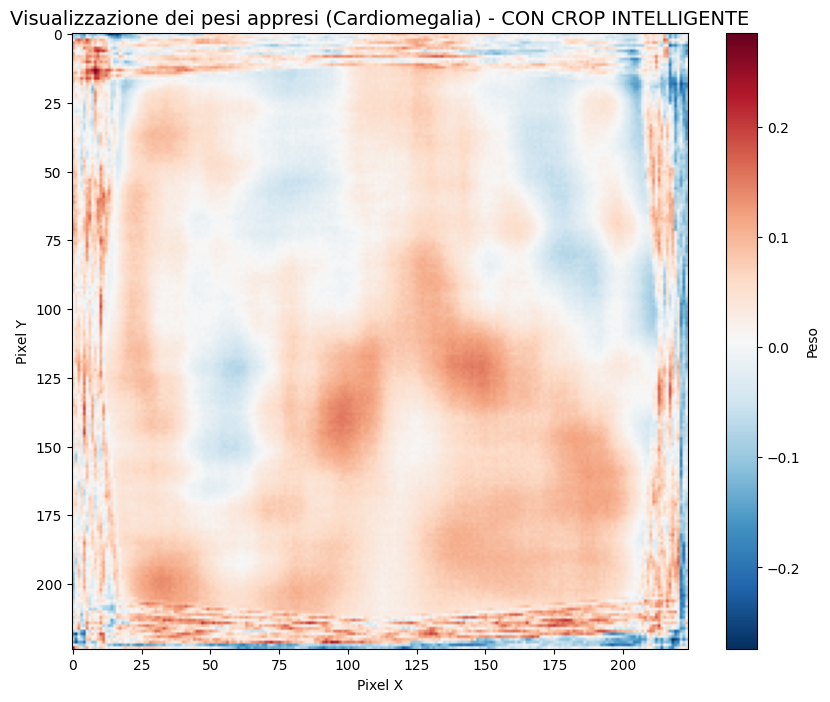

In [18]:

# --- 10. Estrazione e Visualizzazione dei Pesi Migliorati ---

# Estrai i pesi addestrati
trained_weights = model.linear.weight.data.cpu().numpy().squeeze()
trained_weights_reshaped = trained_weights.reshape((224, 224))

print(f"\nPesi estratti con forma appiattita: {trained_weights.shape}")
print(f"Ridimensionati a: {trained_weights_reshaped.shape}")

# Visualizza i nuovi pesi
plt.figure(figsize=(10, 8))
plt.imshow(trained_weights_reshaped, cmap='RdBu_r', origin='upper')
plt.title('Visualizzazione dei pesi appresi (Cardiomegalia) - CON CROP INTELLIGENTE', fontsize=14)
plt.colorbar(label='Peso')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

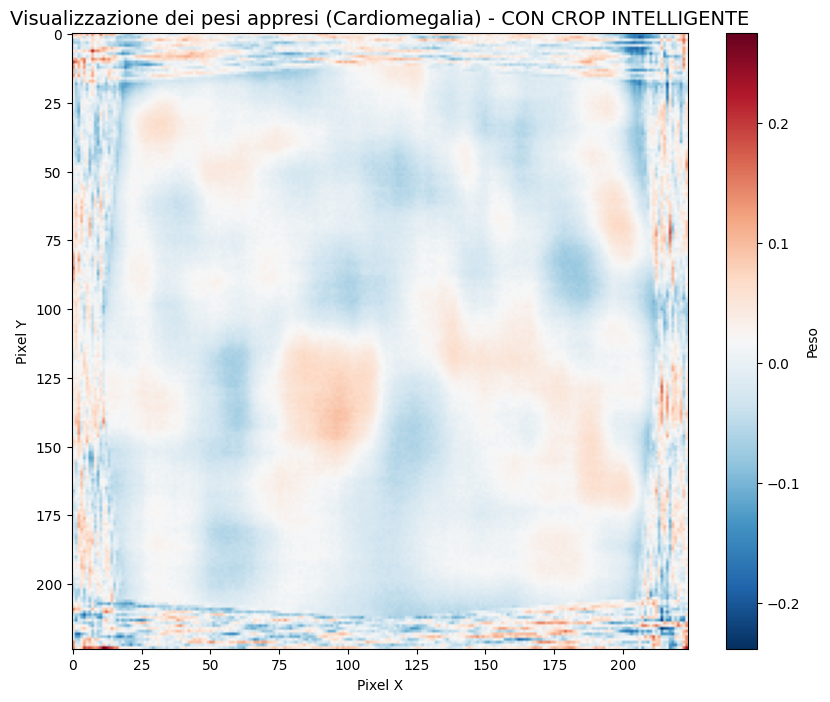

Immagine salvata in: ../data/images/pesi_con_crop.png
Pesi addestrati salvati in: ../data/weights/cardiomegaly_weights_224x224_trained_CROP.npy


In [65]:
# --- 11. Salvataggio dei Pesi ---
# Salva l'immagine dei pesi con crop
plt.figure(figsize=(10, 8))
plt.imshow(trained_weights_reshaped, cmap='RdBu_r', origin='upper')
plt.title('Visualizzazione dei pesi appresi (Cardiomegalia) - CON CROP INTELLIGENTE', fontsize=14)
plt.colorbar(label='Peso')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')

# Salva l'immagine
output_dir = '../data/images'  # o la cartella che preferisci
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, 'pesi_con_crop.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Immagine salvata in: {os.path.join(output_dir, 'pesi_con_crop.png')}")
# Percorso dove salvare i pesi addestrati
output_weights_dir = '../data/weights' # Utilizza il percorso relativo che avevi
os.makedirs(output_weights_dir, exist_ok=True)
weights_output_filepath = os.path.join(output_weights_dir, 'cardiomegaly_weights_224x224_trained_CROP.npy')

np.save(weights_output_filepath, trained_weights_reshaped)
print(f"Pesi addestrati salvati in: {weights_output_filepath}")


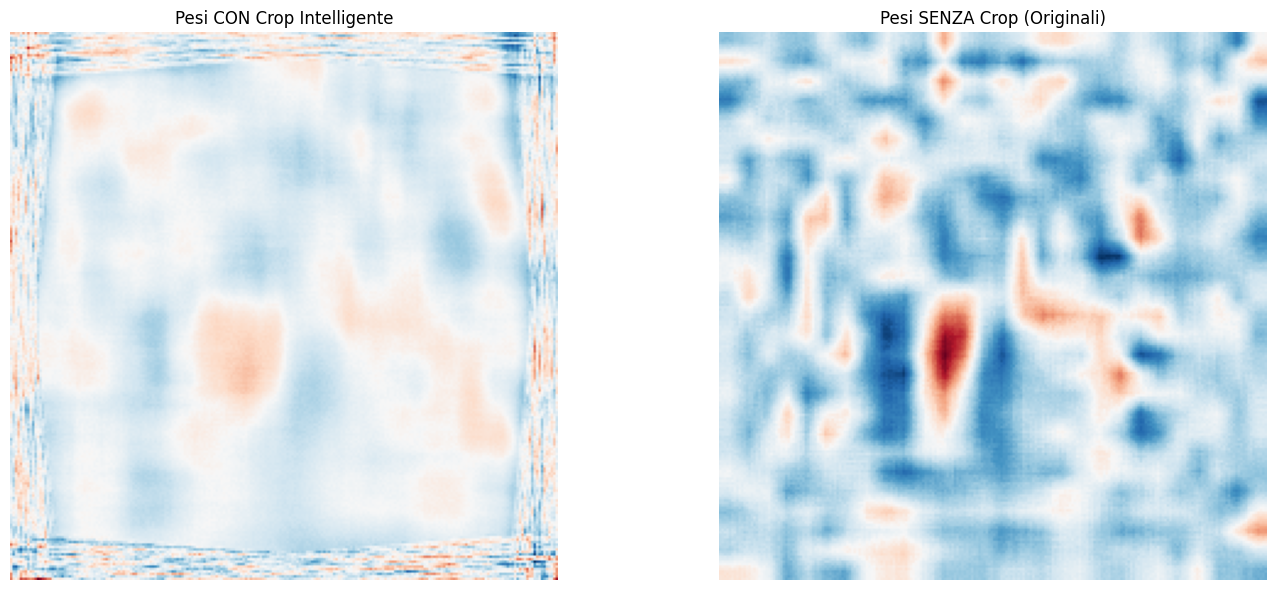

In [64]:
# --- 12. Funzione per Confrontare Prima/Dopo il Crop ---

def compare_weights_distribution(weights_original_path=None):
    """
    Confronta la distribuzione dei pesi prima e dopo il crop
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Pesi con crop (attuali)
    axes[0].imshow(trained_weights_reshaped, cmap='RdBu_r', origin='upper')
    axes[0].set_title('Pesi CON Crop Intelligente')
    axes[0].axis('off')
    
    # Se hai i pesi originali, caricali e visualizzali
    if weights_original_path and os.path.exists(weights_original_path):
        original_weights = np.load(weights_original_path)
        axes[1].imshow(original_weights, cmap='RdBu_r', origin='upper')
        axes[1].set_title('Pesi SENZA Crop (Originali)')
    else:
        axes[1].text(0.5, 0.5, 'Pesi originali\nnon disponibili', 
                    ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Pesi SENZA Crop (Non disponibili)')
    
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Confronta se hai i pesi originali
compare_weights_distribution('../data/weights/cardiomegaly_weights_224x224_trained.npy')